# Grad-CAM 히드맵 시각화

Grad-CAM output 자료를 바탕으로 여러 QR 코드 이미지의 Grad-CAM 결과를 누적하여 히트맵을 생성하는 모듈입니다.

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [16]:
# 환경 설정
phishing_folder = '../data/images/test/phishing'  # change me
model_path = '../best_model.h5'  # change me

In [17]:
# 모델 로드
model = tf.keras.models.load_model(model_path)
print("모델 로드 완료")

모델 로드 완료


In [18]:
# 전처리
def preprocess_image(image_path, target_size=(128, 128)):
    """이미지 전처리"""
    img = tf.keras.preprocessing.image.load_img(image_path, color_mode='grayscale', target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

In [19]:
# Guided Grad-CAM
def guided_grad_cam(model, img, layer_name):
    """Guided Grad-CAM 모델 결정 과정 시각화 함수"""
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        conv_outputs, predictions = grad_model(img_tensor)
        loss = predictions[:, 1]  # 피싱 클래스에 대한 출력
    
    grads = tape.gradient(loss, conv_outputs)[0]
    output = conv_outputs[0]
    
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.zeros(output.shape[0:2], dtype=np.float32)
    
    for index, w in enumerate(weights):
        cam += w * output[:, :, index]
    
    cam = cv2.resize(cam.numpy(), (128, 128))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    
    # Guided Backpropagation
    guided_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output]
    )
    
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        outputs = guided_model(img_tensor)
    
    guided_grads = tape.gradient(outputs, img_tensor)[0]
    guided_grads = np.maximum(guided_grads, 0)  # ReLU
    
    # Guided Grad-CAM
    guided_cam = heatmap[..., np.newaxis] * guided_grads
    guided_cam = cv2.resize(guided_cam, (128, 128))
    
    return guided_cam

In [24]:
# heat-map visualizer
def process_multiple_images(image_folder, model, layer_name='conv2d_2'):
    """여러 이미지의 Grad-CAM 결과를 누적하여 히트맵 생성"""
    accumulated_heatmap = np.zeros((128, 128))
    total_images = 0
    
    valid_extensions = ('.png', '.jpg', '.jpeg')
    
    for filename in os.listdir(image_folder):
        if filename.lower().endswith(valid_extensions):
            try:
                image_path = os.path.join(image_folder, filename)
                img = preprocess_image(image_path)
                
                # Grad-CAM generation
                grad_cam_result = guided_grad_cam(model, img, layer_name)
                
                accumulated_heatmap += grad_cam_result
                total_images += 1
                
                if total_images % 10 == 0:
                    print(f"처리된 이미지: {total_images}")
                
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
    
    if total_images > 0:
        accumulated_heatmap /= total_images
    
    return accumulated_heatmap, total_images


# def visualize_accumulated_heatmap(heatmap, total_images):
#     """누적된 히트맵 시각화"""
#     plt.figure(figsize=(10, 8))
#     plt.imshow(heatmap, cmap='viridis')
#     plt.colorbar(label='Average Activation')
#     plt.title(f'Accumulated Grad-CAM Heatmap\n(Total images: {total_images})')
#     plt.axis('off')
#     plt.show()
    
#     plt.savefig('accumulated_heatmap.png', bbox_inches='tight', dpi=300)

def visualize_accumulated_heatmap(heatmap, total_images, threshold=0.0050):
    """누적된 히트맵 시각화"""
    # 임계값 이하의 값들을 0으로 마스킹
    masked_heatmap = np.where(heatmap >= threshold, heatmap, 0)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(masked_heatmap, cmap='viridis')
    plt.colorbar(label='Average Activation')
    plt.title(f'Accumulated Grad-CAM Heatmap\n(Total images: {total_images})\n(Threshold: {threshold})')
    plt.axis('off')
    plt.show()
    
    plt.savefig('accumulated_heatmap_thresholded.png', bbox_inches='tight', dpi=300)

처리된 이미지: 10
처리된 이미지: 20
처리된 이미지: 30
처리된 이미지: 40
처리된 이미지: 50
처리된 이미지: 60
처리된 이미지: 70
처리된 이미지: 80
처리된 이미지: 90
처리된 이미지: 100
처리된 이미지: 110
처리된 이미지: 120
처리된 이미지: 130
처리된 이미지: 140
처리된 이미지: 150
처리된 이미지: 160
처리된 이미지: 170
처리된 이미지: 180
처리된 이미지: 190
처리된 이미지: 200
처리된 이미지: 210
처리된 이미지: 220
처리된 이미지: 230
처리된 이미지: 240
처리된 이미지: 250


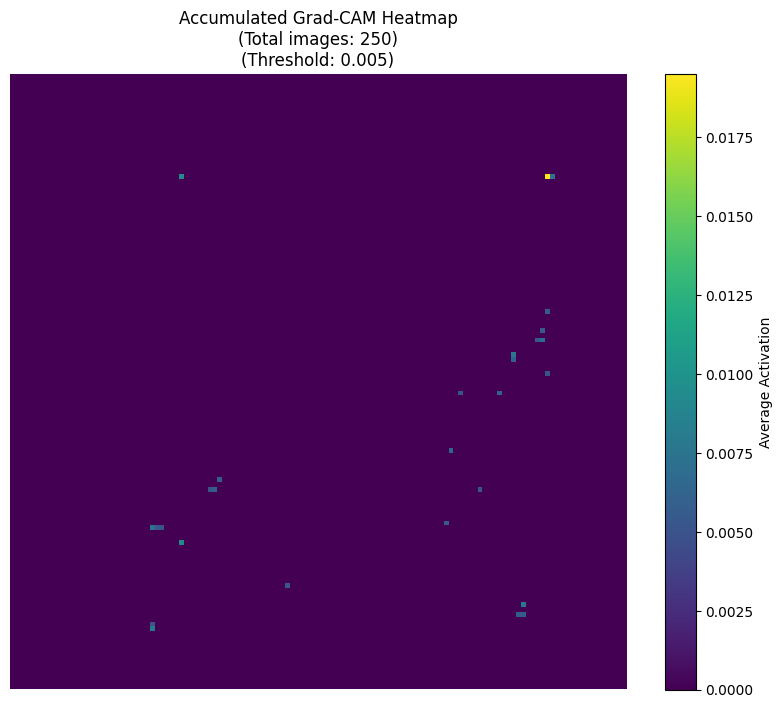

<Figure size 640x480 with 0 Axes>

In [25]:
heatmap, total = process_multiple_images(phishing_folder, model)

visualize_accumulated_heatmap(heatmap, total)